In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
from joblib import Parallel, delayed

Definizione dei parametri: $n_0$ è il numero degli stati di banda per unità di volume; con m indichiamo il numero di layer, $\lambda$ la lunghezza di attenuazione e $z_l$ è la posizione dei layer lungo z


In [2]:
n0 = 0.0002 
m = 2
l = 5
d = 3.34
z_lay = -(np.arange(m)*d)
a = 2.46

Calcoleremo $z_0$ come $\lambda ln(\dfrac{I_0}{I_{STM}})$, tenendo il rapporto $\dfrac{I_{STM}}{I_0}$ == RATIO come parametro in input. Sarà allora "current" il suo reciproco e verrà utilizzato nel calcolo di $z_0$

In [3]:
ratio = 0.05
current= 1/ratio
z0 = l*np.log(current)

In [4]:
#theta = np.radians(np.random.uniform(5, 30, m)) #np.radians convert angles from degrees to radians.
translations = np.random.uniform(-a, a, (m, 2))

#example @18deg
#theta=[np.radians(0),np.radians(18)]
#translations = [[0.0,0.0],[0.0,0.0]]

la funzione $\phi_{\parallel}(x,y)$ si definisce come segue
\begin {equation}
    \phi_{\parallel}(x,y) = 1 - \dfrac{1}{3} cos[\dfrac{2 \pi}{a} (x + \dfrac{y}{\sqrt{3}})] - \dfrac{1}{3} cos[\dfrac{2 \pi}{a} (x - \dfrac{y}{\sqrt{3}})] - \dfrac{1}{3} cos(\dfrac{4 \pi y}{\sqrt{3} a})
\end{equation}

In [5]:
def phi_par(x, y):
    # Funzione analitica come combinazione di seni e coseni
    return 1 - (1/3)*np.cos((2*np.pi)/a * (x+ (y/(np.sqrt(3))))) - (1/3)*np.cos((2*np.pi)/a * (x- (y/(np.sqrt(3))))) - (1/3)*np.cos((4*np.pi*y)/(np.sqrt(3)*a))

In [6]:
def generate_valid_twist_angles(m, min_difference=4, angle_range=(4, 30)):
    min_diff_rad = np.radians(min_difference)
    angle_min_rad = np.radians(angle_range[0])
    angle_max_rad = np.radians(angle_range[1])
    
    angles = []
    while len(angles) < m:
        new_angle = np.random.uniform(angle_min_rad, angle_max_rad)
        if all(abs(new_angle - existing) >= min_diff_rad for existing in angles):
            angles.append(new_angle)
    
    return angles


In [7]:
theta = generate_valid_twist_angles(m, min_difference = 4, angle_range=(4, 30))
# Stampa degli angoli di twist e delle traslazioni per ciascun layer
for i in range(m):
    print(f"Layer {i+1}:")
    print(f"  Angolo di twist (theta_{i+1}): {np.degrees(theta[i]):.2f} gradi")
    print(f"  Traslazione: (t_x, t_y) = ({translations[i][0]:.2f}, {translations[i][1]:.2f})\n")

Layer 1:
  Angolo di twist (theta_1): 4.85 gradi
  Traslazione: (t_x, t_y) = (1.12, 1.05)

Layer 2:
  Angolo di twist (theta_2): 9.47 gradi
  Traslazione: (t_x, t_y) = (-1.70, 0.07)



In [8]:
def rotate_coordinates(x, y, theta):
    x_rot = x * np.cos(theta) - y * np.sin(theta)
    y_rot = x * np.sin(theta) + y * np.cos(theta)
    return x_rot, y_rot

In [9]:
def translate_coordinates(x, y, tx, ty):
    return x + tx, y + ty

In [10]:
def plot_data(data, extent, title, xlabel, ylabel, cbar_label, cmap='inferno', log_scale=False, vmin=None, vmax=None):
    """
    Funzione per plottare dati 2D con una barra dei colori.
    
    Parameters:
    - data: array 2D, i dati da plottare
    - extent: tuple (xmin, xmax, ymin, ymax), limiti degli assi
    - title: string, titolo del grafico
    - xlabel: string, etichetta dell'asse x
    - ylabel: string, etichetta dell'asse y
    - cbar_label: string, etichetta della barra dei colori
    - cmap: string, colormap da usare (default: 'inferno')
    - log_scale: bool, se True, plotta il logaritmo del dato (default: False)
    - vmin: float or None, valore minimo della scala dei colori (default: None)
    - vmax: float or None, valore massimo della scala dei colori (default: None)
    """
    plt.figure(figsize=(8, 6))
    if log_scale:
        data_to_plot = np.log(data + 1e-12)  # Aggiungi 1e-12 per evitare log(0)
    else:
        data_to_plot = data
    
    plt.imshow(data_to_plot, extent=extent, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(label=cbar_label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


Nel dominio diretto, la griglia rappresenta una regione in spazio reale con una certa estensione fisica in angstrom. Definiamo: 
* $L_x$, $L_y$: dimensioni fisiche della griglia in Angstrom 
* $N_x$, $N_y$: numero dei punti sulla griglia lungo x e y

La risoluzione spaziale (ovvero la distanza tra due punti adiacenti della griglia), sarà: 
\begin{equation}
    \Delta i = \dfrac{L_i}{N_i}
\end{equation}

In [11]:
# Parametri della griglia spaziale
L_x = 200.0  # Dimensione della griglia in angstrom (x)
L_y = 200.0  # Dimensione della griglia in angstrom (y)
N_x = 512  # Numero di punti nella griglia (x)
N_y = 512  # Numero di punti nella griglia (y)

In [12]:
#Griglia dei punti nello spazio (x, y)
x = np.linspace(-L_x / 2, L_x / 2, N_x)
y = np.linspace(-L_y / 2, L_y / 2, N_y)
X, Y = np.meshgrid(x, y)

Allora la densità nello spazio tridimensionale sarà dato da
\begin{equation}
    n(x,y,z) = \dfrac{n_0}{m}\sum^m_{i=1} \phi_{\parallel}(x_i , y_i) e^{- \dfrac{|z - z_i|}{\lambda}}
\end{equation}

In [13]:
# Calcolo della densità n(x, y, z) per un dato z
def n_density(x, y, z):
    sum_phi = 0
    for i in range(m):
        X_trans, Y_trans = translate_coordinates(x, y, translations[i][0], translations[i][1])
        # Ruota le coordinate secondo l'angolo di twist del layer i
        X_rot, Y_rot = rotate_coordinates(X_trans, Y_trans, theta[i])
        sum_phi += phi_par(X_rot, Y_rot) * np.exp(-np.abs(z - z_lay[i]) / l)
    return (n0 / m) * sum_phi

In [14]:
# Calcolo della densità n(x, y) sommando i contributi di tutti i layer
def unscaled_density(x, y):
    total_phi = np.zeros_like(x)
    for i in range(m):
        # Applica la traslazione
        X_trans, Y_trans = translate_coordinates(x, y, translations[i][0], translations[i][1])
        # Ruota le coordinate secondo l'angolo di twist del layer i
        X_rot, Y_rot = rotate_coordinates(X_trans, Y_trans, theta[i])
        total_phi += phi_par(X_rot, Y_rot)
    return (n0 / m) * total_phi

Adesso, la visualizzazione della densità deve essere effettuata dal layer on top + epsilon

In [15]:
#attenzione qua#
epsilon = d / 100  # Scelta di epsilon come 1/100 della distanza interlayer
z_density = np.max(z_lay) + epsilon
density = n_density(X, Y, z_density)
unscaled_density = unscaled_density(X, Y)

L'equazione che risolveremo è allora 
\begin{equation}
    \dfrac{I_{STM}}{I_0} = ratio = \dfrac{n(x, y, z)}{n_0}
\end{equation}

In [16]:
# def f_z(z, x, y):
#     # Calcola f(z) = n(x, y, z) / n0 - ratio
#     n_xyz = n_density(x, y, z)  # Calcola la densità n(x, y, z)
#     return n_xyz / n0 - ratio

In [17]:
# def f_prime_z(z, x, y, ratio):
#     """
#     #Derivata di f_z rispetto a z: f'_z(z) = d[n(x, y, z)] / dz
#     """
#     epsilon = 0.01  # Differenza finita per il calcolo numerico
#     return (f_z(z + epsilon, x, y, ratio=0.5) - f_z(z - epsilon, x, y, ratio=0.5)) / (2 * epsilon)

def f_prime_z(z, x, y, dz=1e-5):
    return (f_z(z + dz, x, y) - f_z(z - dz, x, y)) / (2 * dz)

In [18]:
# Parametri della simulazione
z_min = 0.0  # limite inferiore di z
z_max = 200.0  # limite superiore di z

In [19]:
# Funzione obiettivo per trovare z
def target_function(z, x, y, n0, ratio):
    n_val = n_density(x, y, z)  # Calcola la densità a z dato
    return n_val / n0 - ratio

NB: La seguente cella funzionerà nel caso in cui non si volesse parallelizzare con joblib

In [20]:
# # Risolviamo per z su ogni punto della griglia
# Z = np.zeros_like(X)  # Mappa delle altezze z(x, y)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         try:
#             # Risolviamo per z usando il metodo di bisezione
#             Z[i, j] = bisect(target_function, z_min, z_max, args=(X[i, j], Y[i, j], n0, ratio), maxiter=1000, xtol=1e-6)
#         except ValueError:
#             # Se non c'è soluzione nell'intervallo, impostiamo un valore NaN
#             #Z[i, j] = np.nan
#             pass

In [21]:
# Funzione per calcolare z
def calculate_z(i, j, X, Y, n0, ratio, z_min, z_max):
    try:
        return bisect(target_function, z_min, z_max, args=(X[i, j], Y[i, j], n0, ratio), maxiter=1000, xtol=1e-6)
    except ValueError:
        return np.nan

In [22]:
# Funzione per il raffinamento locale
def refine_nan(i, j, X, Y, Z, refine_step, refine_grid_points, n0, ratio, z_min, z_max):
    if np.isnan(Z[i, j]):  # Raffino solo i punti NaN
        x_local = np.linspace(X[i, j] - refine_step, X[i, j] + refine_step, refine_grid_points)
        y_local = np.linspace(Y[i, j] - refine_step, Y[i, j] + refine_step, refine_grid_points)
        X_local, Y_local = np.meshgrid(x_local, y_local)
        z_values = []
        for xl, yl in zip(X_local.ravel(), Y_local.ravel()):
            try:
                z_local = bisect(target_function, z_min, z_max, args=(xl, yl, n0, ratio), maxiter=500, xtol=1e-6)
                z_values.append(z_local)
            except ValueError:
                pass
        if z_values:
            return np.mean(z_values)
    return Z[i, j]  # Restituiamo il valore originale se non c'è raffinamento

In [23]:
# Prima fase: Calcolo di Z
Z = np.zeros_like(X)
Z_flat = Parallel(n_jobs=-1)(
    delayed(calculate_z)(i, j, X, Y, n0, ratio, z_min, z_max) for i in range(X.shape[0]) for j in range(X.shape[1])
)
Z = np.array(Z_flat).reshape(X.shape)

In [24]:
# Raffinamento locale per i NaN
refine_step = 0.5  # Passo per la griglia locale
refine_grid_points = 5  # Numero di punti nella griglia locale

In [25]:
# Seconda fase: Raffinamento locale per i NaN
Z_refined_flat = Parallel(n_jobs=-1)(
    delayed(refine_nan)(i, j, X, Y, Z, refine_step, refine_grid_points, n0, ratio, z_min, z_max)
    for i in range(X.shape[0]) for j in range(X.shape[1])
)
Z = np.array(Z_refined_flat).reshape(X.shape)

NB: La seguente cella funzionerà nel caso in cui non si volesse parallelizzare con joblib

In [26]:
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         if np.isnan(Z[i, j]):  # Raffino solo i punti NaN
#             # Creiamo una griglia locale attorno al punto NaN
#             x_local = np.linspace(X[i, j] - refine_step, X[i, j] + refine_step, refine_grid_points)
#             y_local = np.linspace(Y[i, j] - refine_step, Y[i, j] + refine_step, refine_grid_points)
#             X_local, Y_local = np.meshgrid(x_local, y_local)
#             z_values = []

#             # Proviamo a risolvere per ciascun punto della griglia locale
#             for xl, yl in zip(X_local.ravel(), Y_local.ravel()):
#                 try:
#                     z_local = bisect(target_function, z_min, z_max, args=(xl, yl, n0, ratio), maxiter=500, xtol=1e-6)
#                     z_values.append(z_local)
#                 except ValueError:
#                     pass
            
#             # Se troviamo almeno una soluzione, assegnamo il valore medio
#             if z_values:
#                 Z[i, j] = np.mean(z_values)

In [27]:
# from PIL import Image

# img_Z = Image.fromarray(Z)
# img_Z.save('zeta.tif')

# img_density = Image.fromarray(density)
# img_density.save('density.tif')


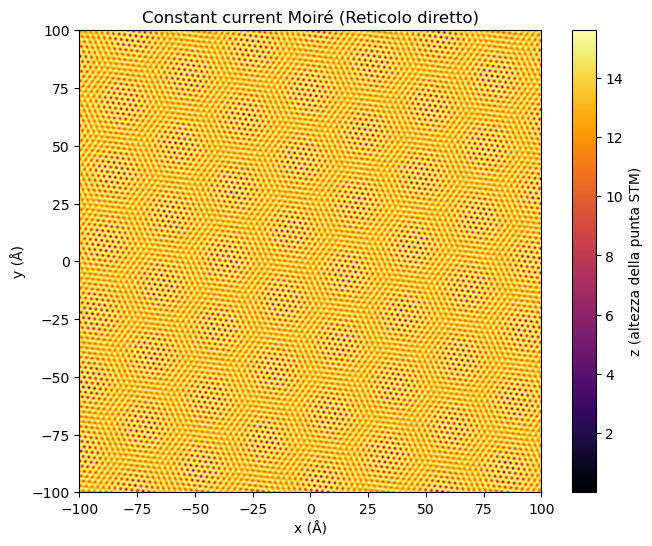

In [28]:
plot_data(
    data=Z, 
    extent=(-L_x / 2, L_x / 2, -L_y / 2, L_y / 2), 
    title="Constant current Moiré (Reticolo diretto)", 
    xlabel="x (Å)", 
    ylabel="y (Å)", 
    cbar_label="z (altezza della punta STM)", 
    cmap='inferno'
)

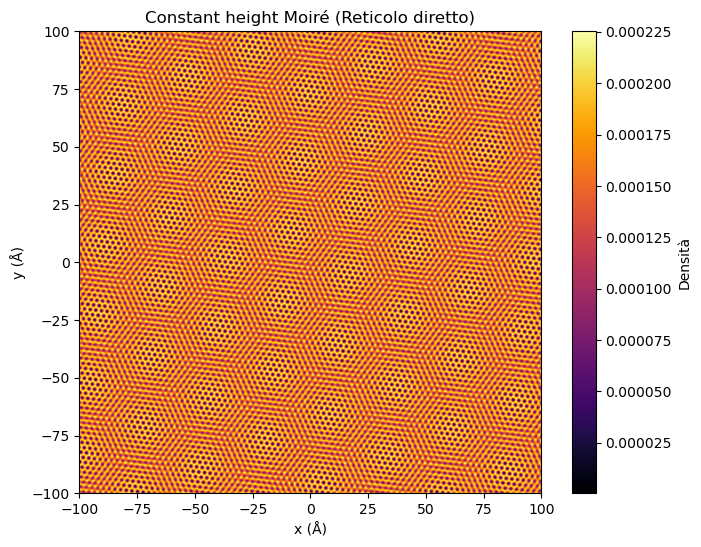

In [29]:
plot_data(
    data=density, 
    extent=(-L_x / 2, L_x / 2, -L_y / 2, L_y / 2), 
    title='Constant height Moiré (Reticolo diretto)', 
    xlabel="x (Å)", 
    ylabel="y (Å)", 
    cbar_label='Densità', 
    cmap='inferno'
)

La trasformata di Fourier trasforma il dominio spaziale nel dominio delle frequenze. Qui, il passo tra i punti della griglia in frequenza è inversamente proporzionale alle dimensioni del dominio spaziale: 
\begin{equation}
    \Delta k_i = \dfrac{2\pi}{L_i}
\end{equation}

dove
* $\Delta k_x$, $\Delta k_y$: distanza tra due punti del dominio di Fourier 
* l'estensione massima del dominio di Fourier sarà determinata da 
\begin{equation}
    k_{max} = \dfrac{\pi}{\Delta x} = \dfrac{N_x 2\pi}{L_x}
\end{equation}

In [30]:
# Calcolo della FFT e visualizzazione nello spazio delle frequenze
#--------------------n(x,y,z)--------------------------------------
n_total_fft = np.fft.fftshift(np.fft.fft2(density))
n_total_fft_magnitude = np.abs(n_total_fft)
#--------------------n_summed(x,y,z)--------------------------------------
unscaled_density_fft = np.fft.fftshift(np.fft.fft2(unscaled_density))
unscaled_density_fft_magnitude = np.abs(unscaled_density_fft)
#--------------------z constant current--------------------------------------
Z_fft = np.fft.fftshift(np.fft.fft2(Z))
Z_fft_magnitude = np.abs(Z_fft)

In [31]:
flattened_n_fft = n_total_fft_magnitude.flatten()
flattened_z_fft = Z_fft_magnitude.flatten()
mean_n_flat = np.mean(flattened_n_fft)
std_n_flat = np.std(flattened_n_fft)
mean_z_flat = np.mean(flattened_z_fft)
std_z_flat = np.std(flattened_z_fft)

print(mean_n_flat, std_n_flat)
print(mean_z_flat, std_z_flat)
sorted_n_flatten = np.sort(flattened_n_fft)
sorted_z_flatten = np.sort(flattened_z_fft)
# top_n_100_values = np.sort(flattened_n_fft)[::-1][:100]
# top_z_100_values = np.sort(flattened_z_fft)[::-1][:100]


0.0012668782852630186 0.08038874668188108
152.41354028631807 6865.912648267886


In [32]:
# Trova l'indice del valore massimo nel flatten (senza ordinamento)
max_index_n_flat = np.argmax(flattened_n_fft)
max_index_z_flat = np.argmax(flattened_z_fft)

# Risali agli indici bidimensionali
max_index_n_2d = np.unravel_index(max_index_n_flat, n_total_fft_magnitude.shape)
max_index_z_2d = np.unravel_index(max_index_z_flat, Z_fft_magnitude.shape)

print("Valore massimo nella densità flatten:", flattened_n_fft[max_index_n_flat])
print("Valore massimo nella z flatten:", flattened_z_fft[max_index_z_flat])
print("Indici bidimensionali del valore massimo in n:", max_index_n_2d)
print("Indici bidimensionali del valore massimo in z:", max_index_z_2d)

Valore massimo nella densità flatten: 39.391599769902555
Valore massimo nella z flatten: 3477694.332365144
Indici bidimensionali del valore massimo in n: (256, 256)
Indici bidimensionali del valore massimo in z: (256, 256)


In [33]:
n_10p_valori = int(len(sorted_n_flatten) * 0.1)
valori_n_top10 = sorted_n_flatten[-n_10p_valori:]
# Calcola media e deviazione standard
media_n_top10 = np.mean(valori_n_top10)
std_n_top10 = np.std(valori_n_top10)

print(f"Media del 10% più alto in n: {media_n_top10}")
print(f"Deviazione standard del 10% più alto in n: {std_n_top10}")

z_10p_valori = int(len(sorted_z_flatten) * 0.1)
valori_z_top10 = sorted_z_flatten[-z_10p_valori:]
# Calcola media e deviazione standard
media_z_top10 = np.mean(valori_z_top10)
std_z_top10 = np.std(valori_z_top10)

print(f"Media del 10% più alto in z: {media_z_top10}")
print(f"Deviazione standard del 10% più alto in z: {std_z_top10}")

Media del 10% più alto in n: 0.01103265278179733
Deviazione standard del 10% più alto in n: 0.25400405219922656
Media del 10% più alto in z: 804.4960790322983
Deviazione standard del 10% più alto in z: 21700.794302492


In [34]:
clean_density_fft = np.copy(n_total_fft_magnitude)
clean_density_fft[max_index_n_2d] = mean_n_flat
clean_z_fft = np.copy(Z_fft_magnitude)
clean_z_fft[max_index_z_2d] = mean_z_flat

In [35]:
# Coordinate della griglia nel dominio delle frequenze
k_x = np.fft.fftshift(np.fft.fftfreq(N_x, d=L_x / N_x)) * 2 * np.pi
k_y = np.fft.fftshift(np.fft.fftfreq(N_y, d=L_y / N_y)) * 2 * np.pi
KX, KY = np.meshgrid(k_x, k_y)

In [36]:
max = np.max(n_total_fft_magnitude)
min = np.min(n_total_fft_magnitude)
mean= np.mean(n_total_fft_magnitude)
print(max, min, mean)

39.391599769902555 2.988126954404258e-07 0.0012668782852630189


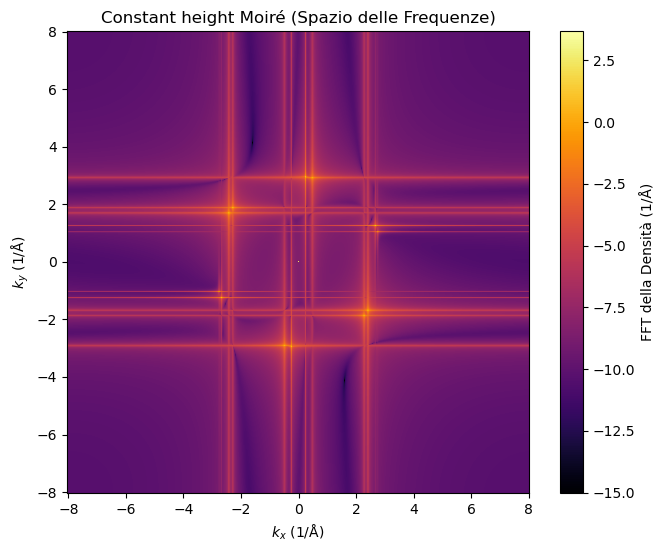

In [37]:
plot_data(
    data=n_total_fft_magnitude, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant height Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno',
    log_scale=True
)

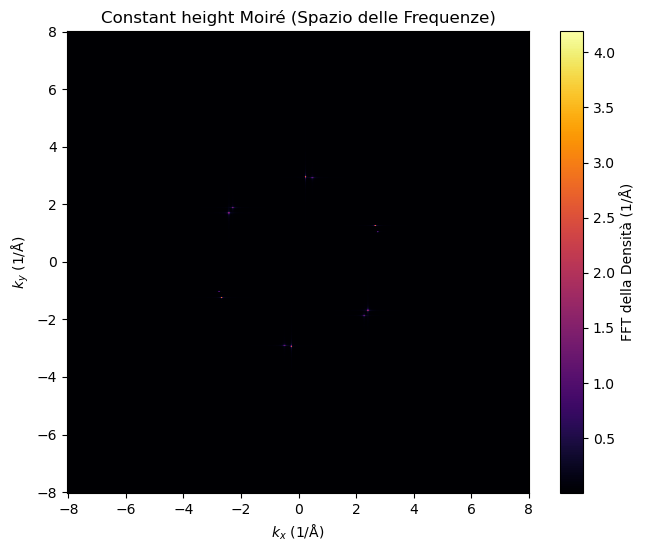

In [38]:
plot_data(
    data=clean_density_fft, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant height Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno', 
    log_scale=False
)

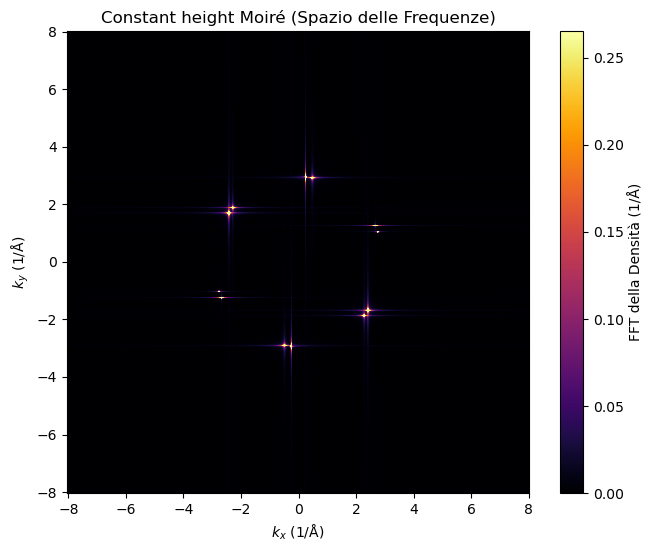

In [43]:
plot_data(
    data= clean_density_fft, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant height Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno',
    vmin = 0,
    vmax = media_n_top10+std_n_top10,
    log_scale=False
)

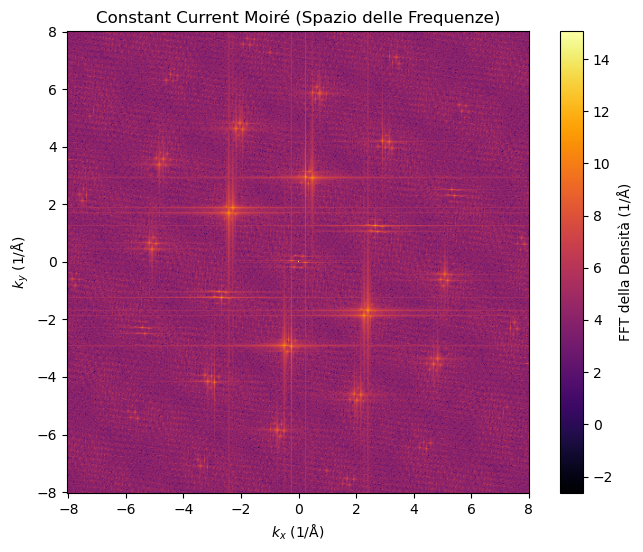

In [40]:
plot_data(
    data= Z_fft_magnitude, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant Current Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno', 
    log_scale=True
)

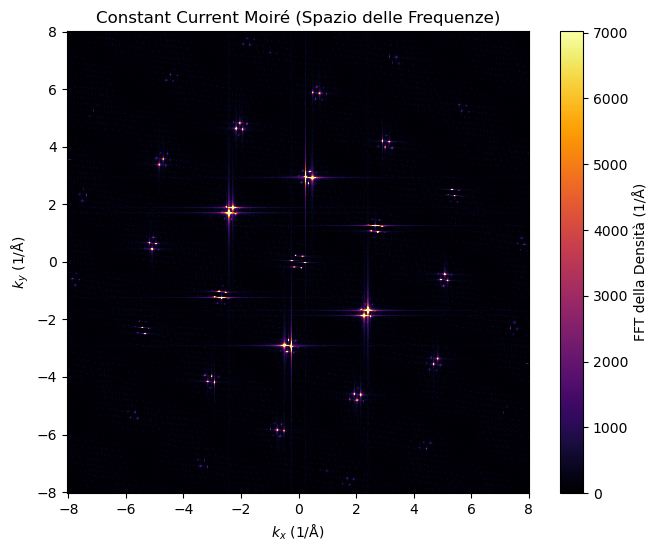

In [41]:
plot_data(
    data= clean_z_fft, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant Current Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno',
    vmin = 0,
    vmax = mean_z_flat+std_z_flat,
    log_scale=False
)

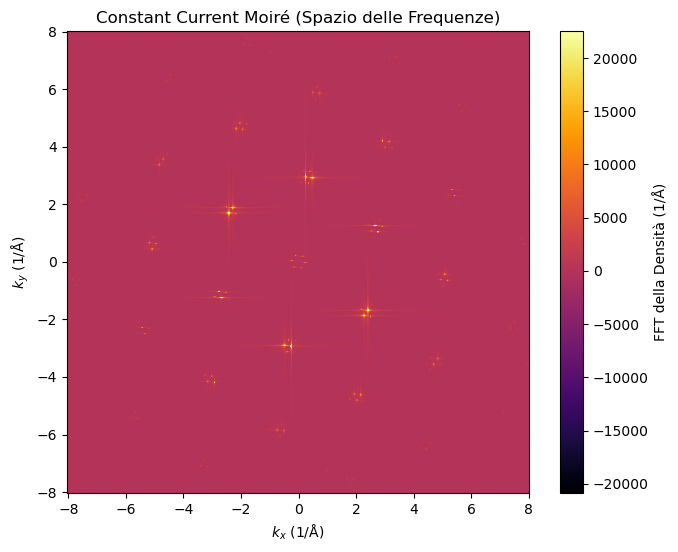

In [42]:
plot_data(
    data= clean_z_fft, 
    extent=(k_x.min(), k_x.max(), k_y.min(), k_y.max()), 
    title="Constant Current Moiré (Spazio delle Frequenze)", 
    xlabel='$k_x$ (1/Å)', 
    ylabel='$k_y$ (1/Å)', 
    cbar_label='FFT della Densità (1/Å)', 
    cmap='inferno',
    vmin = media_z_top10-std_z_top10,
    vmax = media_z_top10+std_z_top10,
    log_scale=False
)